# 文本情感分析：二分类

## 1. 导入包

In [1]:
import pandas as pd
import os
import numpy as np
import jieba
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import warnings
import bz2
warnings.filterwarnings('ignore')


# 首先导入数据集,微博评论语料库\
os.chdir(r'D:\code\WeiboCommentEmotionAnalysis')
data = pd.read_csv(r'weibo_senti_100k.csv',encoding='utf-8')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119988 entries, 0 to 119987
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   label   119988 non-null  int64 
 1   review  119988 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


### 分别获取评论原始文本以及文本极性

In [2]:
data.head()

,label,review
0,1,﻿更博了，爆照了，帅的呀，就是越来越爱你！生快傻缺[爱你][爱你][爱你]
1,1,@张晓鹏jonathan 土耳其的事要认真对待[哈哈]，否则直接开除。@丁丁看世界 很是细心...
2,1,姑娘都羡慕你呢…还有招财猫高兴……//@爱在蔓延-JC:[哈哈]小学徒一枚，等着明天见您呢/...
3,1,美~~~~~[爱你]
4,1,梦想有多大，舞台就有多大![鼓掌]


In [3]:
review = data.review.tolist()              # 获取评论数据
label = data.label.tolist()                # 文本极性,用1和0表示

In [4]:
len(label) == len(review)

True

+ 将dataframe转换为列表,将正向数据和负面数据都放在一起

In [5]:
with open("embeddings/sgns.zhihu.bigram", 'wb') as new_file, open("embeddings/sgns.zhihu.bigram.bz2", 'rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [6]:
### 将词向量模型转化为gensim的KeyedVectors格式
word_vectors = KeyedVectors.\
        load_word2vec_format('embeddings/sgns.zhihu.bigram', binary=False)

In [7]:
# test_words = ['']
# word_vectors.doesnt_match(test_words)

In [8]:
embeddingDim = word_vectors['合肥工业大学'].shape[0]

In [9]:
# 使用keras
from keras.models import Sequential
from keras.layers import Dense, GRU, Embedding, LSTM
from keras.layers import Bidirectional
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
import re
import tensorflow as tf

In [10]:
train_tokens = []
for text in review:
    # 首先去除所有的标点符号
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    cut = jieba.cut(text)
    cutList = [i for i in cut]
    for i,word in enumerate(cutList):
        try:
            # 这一步讲
            cutList[i] = word_vectors.key_to_index[word]
        except:
            cutList[i] = 0
    train_tokens.append(cutList)


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\29236\AppData\Local\Temp\jieba.cache
Loading model cost 0.750 seconds.
Prefix dict has been built successfully.


In [11]:
train_tokens[0]
len(train_tokens)

119988

train_tokens[0

**标准化索引长度**
> 选择最具代表性的索引长度,如果使用最长评论的长度来进行索引化,会造成大量计算资源的浪费

In [12]:
tokenLens = [len(tokens) for tokens in train_tokens]
# tokenLens

In [13]:
np.mean(tokenLens)

33.86023602360236

当标准长度为$\mu + 2 * \sigma$时，可以覆盖$95\%$的数据

In [14]:
maxTokens = int(np.mean(tokenLens) + 2 * np.std(tokenLens))
np.sum(np.array(tokenLens) < maxTokens) / len(tokenLens)

0.9578124479114578

In [15]:
maxTokens

78

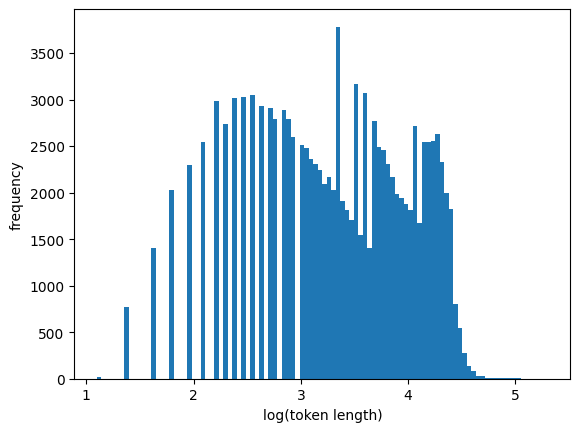

In [16]:
plt.hist(np.log(tokenLens),bins=100)
plt.xlabel('log(token length)')
plt.ylabel('frequency')
plt.show()

**反向Tokenize**,方便进行debug

In [17]:
def reverseTokenize(tokens):
    """
    this function is used to reverse the tokenization process
    """
    text = ''
    if tokens!=0:
        for i in tokens:
            if tokens!=0:
                text = text + word_vectors.index_to_key[i]
            else:
                text = text + ' '
        return text

In [18]:
## 试试reverseTokenize函数能否正常使用
reverseTokenize(train_tokens[1000])

'我想到了，，主人，激光洗的时候还被击碎了，鱼眼睛[，转圈]，v谁不会自己来V:，:[哈哈]'

In [19]:
len(word_vectors)

259936

In [20]:
# embeddingDim = 300

In [21]:
MAX_WORDS = 50_000
embeddingMatrix = np.zeros((MAX_WORDS,embeddingDim))

for i in range(MAX_WORDS):
    embeddingMatrix[i,:] = word_vectors[word_vectors.index_to_key[i]]
    # 遍历,将词向量模型之中的数据赋值给指定的行
embeddingMatrix = embeddingMatrix.astype('float32')
embeddingMatrix.shape

(50000, 300)

In [22]:
## 检查index是否一一对应
np.sum(word_vectors[word_vectors.index_to_key[0]] == embeddingMatrix[0,:])

300

In [23]:
embeddingMatrix.shape

(50000, 300)

In [24]:
train_tokens[100]

[1261, 1862, 1046, 0, 3, 163, 146, 3]

**padding和truncating**
由于文本转换为tokens以后,每一串索引的长度并不相等,所以,为了方便模型的训练,我们在此将其长度进行标准化
对于长度不满标准长度的数据,在文本索引的前边填充0

In [25]:
"""
pad_sequence()函数将每个序列填充为相同的长度，长度为序列中最长的长度,缺省值为0,
如果指定了maxlen,则所有序列都会被截断为该长度,截断发生在序列的开始位置
padding='pre'表示在序列前面填充, padding='post'表示在序列后面填充
truncating='pre'表示截断序列的前面部分, truncating='post'表示截断序列的后面部分
"""
trainPad = pad_sequences(train_tokens,maxlen = maxTokens,padding = 'pre',truncating = 'pre')
trainPad.shape
# trainPad[100].shape

(119988, 78)

In [26]:
trainPad[trainPad >= MAX_WORDS] = 0
len(trainPad[100])

78

In [27]:
IndexArray = np.array(label)
type(IndexArray)

numpy.ndarray

**使用sklearn的函数来分割数据,创建练习数据以及测试数据,占比为0.9与0.1**


In [28]:
from sklearn.model_selection import train_test_split
reviewTrain, reivewTest, indexTrain,indexTest = train_test_split(trainPad,
                                                                 IndexArray,
                                                                 test_size=0.1,
                                                                 random_state=12)

**创建测试模型,向模型之中添加LTSM模型**



In [29]:
model = Sequential()

In [30]:
model.add(Embedding(MAX_WORDS,
                    embeddingDim,
                    weights=[embeddingMatrix],
                    input_length=maxTokens,
                    trainable=False))

In [31]:
layers1 = Bidirectional(LSTM(units=32, return_sequences=True))
model.add(layers1)
model.add(LSTM(units=16, return_sequences = False))

### 构建模型
使用BiLSTM
Embedding之后,一层使用BiLSTM返回sequences,然后第二层16的个单元的LSTM不返回sequence,只返回最终结果,最后是全连接层,使用sigmoid激活函数输出结果

In [32]:
model.add(Dense(1, activation='sigmoid'))        
optimizer = Adam(lr=1e-3)      # 使用Adam优化器,学习率为1e-3

In [33]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])       # 报错是因为混用了tensorflow和keras的接口

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 78, 300)           15000000  
                                                                 
 bidirectional (Bidirectiona  (None, 78, 64)           85248     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 15,090,449
Trainable params: 90,449
Non-trainable params: 15,000,000
_________________________________________________________________


**最后的输出应该是(None,1),也就是仅仅输出情绪是正面还是负面的一个数据,而非是目前的(None,10)**

In [35]:
path_checkpoint = 'sentiment_checkpoint.keras'    # 建立储存权重的文件夹
checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                monitor='val_loss',
                                verbose=1,
                                save_weights_only=True,            
                                save_best_only=True)

In [36]:
# 加载已训练模型
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)
    

In [37]:
# 定义early stopping,当验证集的loss不再下降时,停止训练
earlystopping = EarlyStopping(monitor='val_loss',
                                patience=3, verbose=1)
                                

In [38]:
# 自动降低学习率
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1,
                                min_lr=1e-5,
                                patience=0,
                                verbose=1)

In [39]:
# 定义回调函数
callbacks = [
    earlystopping,
    checkpoint,
    reduce_lr
]

### 开始训练

In [40]:
model.fit(reviewTrain,
            indexTrain,
            validation_split=0.1,
            epochs=20,
            batch_size=128,
            callbacks=callbacks)

Epoch 1/20
760/760 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9830
Epoch 1: val_loss improved from inf to 0.04080, saving model to sentiment_checkpoint.keras
760/760 [==============================] - 120s 151ms/step - loss: 0.0397 - accuracy: 0.9830 - val_loss: 0.0408 - val_accuracy: 0.9833 - lr: 0.0010
Epoch 2/20
760/760 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9815
Epoch 2: val_loss did not improve from 0.04080

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
760/760 [==============================] - 106s 139ms/step - loss: 0.0423 - accuracy: 0.9815 - val_loss: 0.0417 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 3/20
760/760 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9832
Epoch 3: val_loss did not improve from 0.04080

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
760/760 [==============================] - 108s 142ms/step - loss: 0.0385 -

In [41]:
result = model.evaluate(reivewTest, indexTest)
print("Accuracy: {0:.2%}".format(result[1]))

375/375 [==============================] - 9s 23ms/step - loss: 0.0409 - accuracy: 0.9820
Accuracy: 98.20%


## 模型训练结束
接下来输入文本爬取的文本进行测试
**此函数用于获取文本的极性**


In [48]:
import re
EmtionList = []
def getSentiment(comment):
    # print(comment)
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",comment)
    cut = jieba.cut(text)
    cut = [i for i in cut]
    for i,word in enumerate(cut):
        try:
            cut[i] = word_vectors.key_to_index[word]
            if cut[i] >= MAX_WORDS:
                cut[i] = 0
        except KeyError:
            cut[i] = 0
    tokens = pad_sequences([cut], maxlen=maxTokens,
                            padding='pre', truncating='pre')
    # 和此前预处理的步骤一样,这部分进行对文本的预处理
    result = model.predict(tokens)
    EmtionList.append(result)
    # if result[0] >= 0.5:
    #     print('{0}是Positive,估值为{1}'.format(comment,result[0]))
    # else:
    #     print('{0}情绪偏向Negative,估值为{1}'.format(comment,result[0]))

**读取文件**

In [49]:
import os
# os.chdir(r'C:\Users\moonchild\OneDrive\MathandModel\NLP\WeiboCrapperAndEmotionAnalysis')
resList = []
with open(r'bilibili2.txt','r',encoding='utf-8') as res:
    for i in res:
        resList.append(i)

In [50]:
for comment in resList:
    getSentiment(comment)

1/1 [==============================] - 0s 40ms/step


In [51]:
EmtionList = [emtion[0][0] for emtion in EmtionList]
EmtionList

[0.581375,
 0.4218919,
 0.5373963,
 0.45446196,
 0.5419996,
 0.631416,
 0.8924988,
 0.6711539,
 0.47039977,
 0.7827985,
 0.00021037656,
 0.47786817,
 0.93562657,
 0.46770594,
 0.53329235,
 0.9306008,
 0.6619589,
 0.89635885,
 0.4310715,
 0.46544668,
 0.6948194,
 0.9360343,
 0.5301683,
 0.7879458,
 0.47755677,
 0.7879458,
 0.4828412,
 0.5501439,
 0.8358264,
 0.7677508,
 0.53967524,
 0.80483526,
 0.78377175,
 0.8612952,
 0.48788208,
 0.7879458,
 0.7879458,
 0.8743958,
 0.7879458,
 0.42231968,
 0.576139,
 0.71451205,
 0.7862554,
 0.6422902,
 0.55464983,
 0.6550586,
 0.4486896,
 0.8448165,
 0.9981743,
 0.39401984,
 0.4126774,
 0.35296345,
 0.7879458,
 0.83789766,
 0.52297014,
 0.5889792,
 0.92914516,
 0.6335893,
 0.7879458,
 0.51544815,
 0.7879458,
 0.47677568,
 0.7879458,
 0.45321056,
 0.7879458,
 0.48214725,
 0.7879458,
 0.6587775,
 0.7879458,
 0.6498989,
 0.7879458,
 0.8932905,
 0.7879458,
 0.5587294,
 0.7879458,
 0.61233985,
 0.7879458,
 0.6491944,
 0.7879458,
 0.55985254,
 0.7879458,


## 将获得的结果绘制为图表

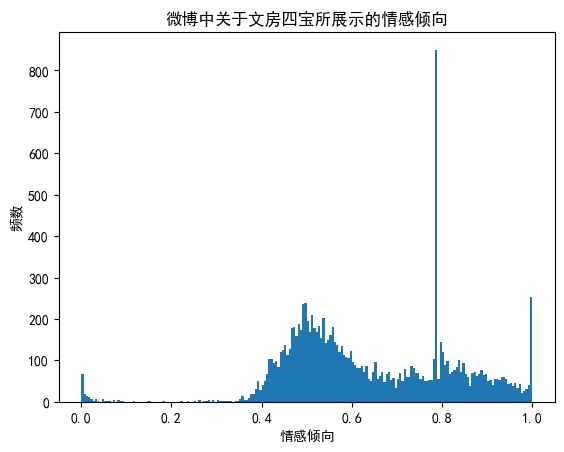

In [52]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题


plt.hist(EmtionList,bins=200)
plt.xlabel('情感倾向')
plt.ylabel('频数')
plt.title("微博中关于文房四宝所展示的情感倾向")
plt.show()

对于这个list，我们将$[0.03]$区间的内容判断为neg，将$[0.3,0.6]$的内容判断为中中性，$[0.6,1]$的内容判断为positive。

In [53]:
neg,median,pos = 0,0,0
for emotion in EmtionList:
    if emotion<0.3:
        neg+=1
    elif emotion>=0.3 and emotion<0.6:
        median+=1
    else:
        pos+=1
neg,median,pos = neg/len(EmtionList),median/len(EmtionList),pos/len(EmtionList)

Text(0.5, 1.0, '关于文房四宝的情感倾向饼图')

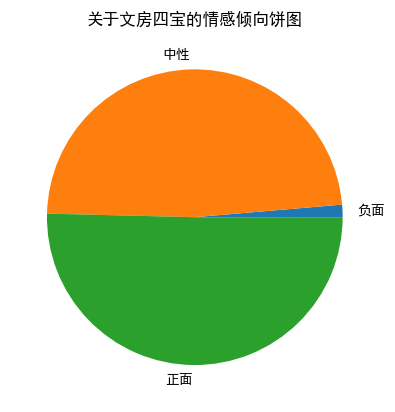

In [54]:
plt.pie(np.array([neg,median,pos]),labels=['负面','中性','正面'])
plt.title('关于文房四宝的情感倾向饼图')